In [124]:
import trace.tracepol as tp
import numpy as np
from astropy.io import fits
import itsosspipeline as soss
import sys
import os
import specgen.spgen as spgen
from sys import path

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.
%matplotlib notebook

import box_kim

In [142]:
# Matplotlib defaults
plt.rc('figure', figsize=(9,5))
plt.rc('font', size=12)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=1)

In [126]:
WORKING_DIR = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/'

sys.path.insert(0, "/genesis/jwst/jwst-ref-soss/fortran_lib/")

# Read in all paths used to locate reference files and directories
config_paths_filename = os.path.join(WORKING_DIR, 'jwst-mtl_configpath_kim.txt')
pathPars = soss.paths()
soss.readpaths(config_paths_filename, pathPars)

# Create and read the simulation parameters
simuPars = spgen.ModelPars()              # Set up default parameters
simuPars = spgen.read_pars(pathPars.simulationparamfile, simuPars)    # Read in parameter file

spgen.py - warning - fix the bug with orderlist


In [127]:
def normalization(f_lambda, t1, t4):
    """
    Normalize transit light curve by mean during out of transit.
    """
    hors_t = np.concatenate((f_lambda[: t1 + 1], f_lambda[t4:]))
    mean = np.mean(hors_t)
    return f_lambda / mean

def transit_depth(f_lambda, t2, t3):
    """
    Calculates mean flux value during transit.
    """
    return np.mean(f_lambda[t2: t3+1])

Load simulations

In [154]:
gain = 1.6   # é per adu

# CHOOSE simulations to use/compare: CHANGE True's and False's
# CHANGE 1 and 2 values for data variable also!!!
if False:   # Photon noise, no DMS
    noisy_photon = fits.open(WORKING_DIR + 'IDTSOSS_clear_noisy--photon.fits')
    data_0 = noisy_photon[1].data[:,-1]     # Images of flux [adu/s]
    simulation_0 = 'Photon noise, no DMS'
    
if False:   # Photon noise, after DMS
    noisy_rateints_photon = fits.open(WORKING_DIR + 'IDTSOSS_clear_noisy--photon_rateints.fits')
    data_noisy_rateints_photon = noisy_rateints_photon[1].data     # Images of flux [adu/s]
    #delta_noisy = noisy_rateints_photon[2].data     # Errors [adu/s]
    dq = noisy_rateints_photon[3].data  # Data quality
    i = np.where(dq % 2 != 0)  # Odd values of dq = DO NOT USE these pixels
    data_noisy_rateints_photon[i[0], i[1], i[2]] = 0.
    #delta_noisy[i[0], i[1], i[2]] = 0.
    data_0 = data_noisy_rateints_photon
    simulation_0 = 'Photon noise, after DMS'
    
if False:   # Detector noise, no DMS
    noisy_detector = fits.open(WORKING_DIR + 'IDTSOSS_clear_noisy--detector.fits')
    data_0 = noisy_detector[1].data[:,-1]     # Images of flux [adu/s]
    simulation_0 = 'Detector noise, no DMS'
    
if True:   # Detector noise, after DMS
    noisy_rateints_detector = fits.open(WORKING_DIR + 'IDTSOSS_clear_noisy--detector_rateints.fits')
    data_noisy_rateints_detector = noisy_rateints_detector[1].data     # Images of flux [adu/s]
    #delta_noisy = noisy_rateints_detector[2].data     # Errors [adu/s]
    dq = noisy_rateints_detector[3].data  # Data quality
    i = np.where(dq % 2 != 0)  # Odd values of dq = DO NOT USE these pixels
    data_noisy_rateints_detector[i[0], i[1], i[2]] = 0.
    #delta_noisy[i[0], i[1], i[2]] = 0.
    data_2 = data_noisy_rateints_detector
    simulation_2 = 'Detector noise, after DMS'

if True:   # Noiseless
    clear = fits.open(WORKING_DIR + 'IDTSOSS_clear.fits')
    data_1 = clear[1].data[:,-1]  # Images of flux [adu/s]  (Last image of each integration)
    simulation_1 = 'Noiseless'
    
    # Convert data from fits files to float (fits precision is 1e-8)
    data_noiseless = [im_ord.astype('float64') for im_ord in data_clear]  

    
# Convert data from fits files to float (fits precision is 1e-8)
data_1 = data_1.astype('float64', copy=False)
data_2 = data_2.astype('float64', copy=False)
#delta_noisy = delta_noisy.astype('float64', copy=False)

print('Simulation 1:', simulation_1)
print('Simulation 2:', simulation_2)

Simulation 1: Noiseless
Simulation 2: Detector noise, after DMS


Extraction

In [155]:
# BOX EXTRACTION
radius_pixel = 30  # Radius for box extraction

# Position of trace for box extraction
x, y, w = box_kim.readtrace(os=1)

# Extractions
fbox_1 = np.zeros(shape=(np.shape(data_1)[0], np.shape(data_1)[2]), dtype='float')
fbox_2 = np.zeros(shape=(np.shape(data_2)[0], np.shape(data_2)[2]), dtype='float')

oversample = simuPars.noversample  # Oversampling of the simulation

for t in range(np.shape(data_1)[0]):  # For each image of the timeseries
    fbox_1[t] = box_kim.flambda_adu(x, data_1[t], y, radius_pixel=radius_pixel) / oversample * gain   # [e⁻/s]
    fbox_2[t] = box_kim.flambda_adu(x, data_2[t], y, radius_pixel=radius_pixel) / oversample * gain   # [e⁻/s]

In [156]:
t1 = 95   # * 5. * 5.491 / 60  # [min]
t2 = 155   # * 5. * 5.491 / 60  # [min]
t3 = 283   # * 5. * 5.491 / 60  # [min]
t4 = 343   # * 5. * 5.491 / 60  # [min]

lam_array = w

f_array_1 = np.nan_to_num(fbox_1)
f_array_2 = np.nan_to_num(fbox_2)

time = np.arange(f_array_1.shape[0])
time_min = time * 5. * 5.491 / 60.  # [min]
time_fit = np.concatenate((time[:t1], time[t4:]))

In [157]:
# White light curve
f_white_1 = np.sum(f_array_1, axis=1)
f_white_2 = np.sum(f_array_2, axis=1)

# Normalize white light curve
f_white_1_norm = normalization(f_white_1, t1, t4)
f_white_2_norm = normalization(f_white_2, t1, t4)

<IPython.core.display.Javascript object>


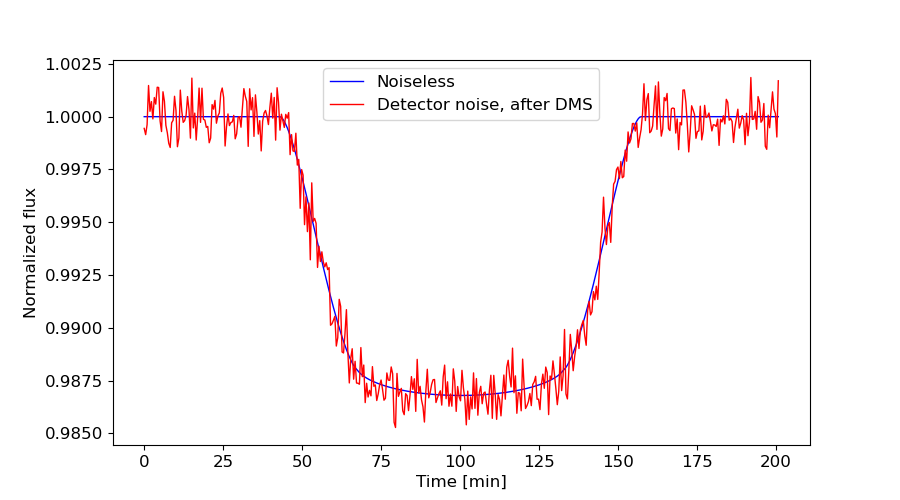

In [158]:
plt.figure()
plt.plot(time_min, f_white_1_norm, color='b', label=simulation_1)
plt.plot(time_min, f_white_2_norm, color='r', label=simulation_2)
plt.xlabel('Time [min]')
plt.ylabel(r'Normalized flux')
plt.legend()
plt.show()

In [159]:
# Relative difference
relatDiff_white = box_kim.relative_difference(f_white_2_norm, f_white_1_norm)

<IPython.core.display.Javascript object>


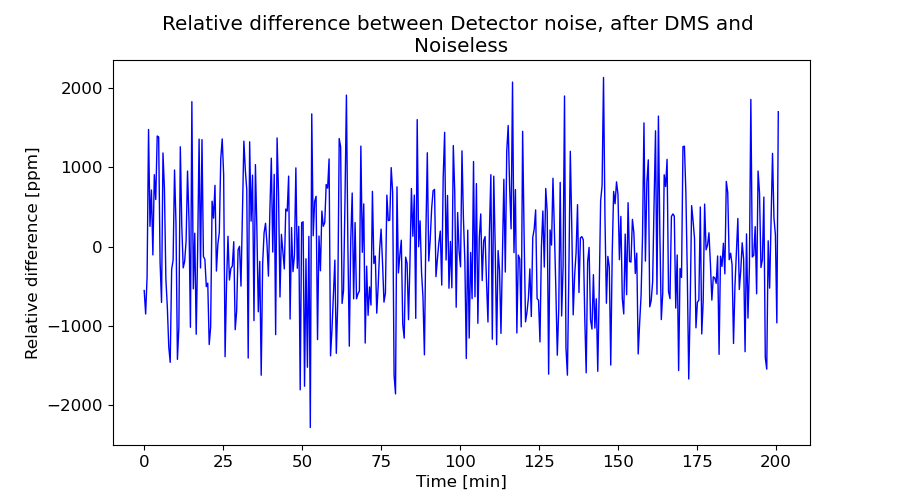

In [160]:
plt.figure()
plt.plot(time_min, relatDiff_white * 1e6, color='b')
plt.xlabel('Time [min]')
plt.ylabel(r'Relative difference [ppm]')
plt.title('Relative difference between {} and \n{}'.format(simulation_2, simulation_1))
plt.show()